In [1]:
import logging
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

First of all, let's load the dataset and filter it so that we can get only those orders which have 5 or more products on it:


In [8]:
data=pd.read_csv("feature_frames.csv")
filtered_data = data[data['user_order_seq'] > 5]
#print(filtered_data.head())
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Las primeras filas del DataFrame son:\n%s", filtered_data.head().to_string())


2024-02-02 21:26:10,715 - INFO - Las primeras filas del DataFrame son:
        variant_id     product_type       order_id        user_id           created_at           order_date  user_order_seq  outcome  ordered_before  abandoned_before  active_snoozed  set_as_regular  normalised_price  discount_pct       vendor  global_popularity  count_adults  count_children  count_babies  count_pets  people_ex_baby  days_since_purchase_variant_id  avg_days_to_buy_variant_id  std_days_to_buy_variant_id  days_since_purchase_product_type  avg_days_to_buy_product_type  std_days_to_buy_product_type
7   33826472919172  ricepastapulses  2808549900420  3437017956484  2020-10-06 14:24:26  2020-10-06 00:00:00              13      0.0             0.0               0.0             0.0             0.0          0.081052      0.053512  clearspring           0.038462           2.0             0.0           0.0         0.0             2.0                            33.0                        42.0                  

LINEAL MODELS

for the POC, we will start analysing some linear models.

Before doing so, let's check which variables may be more influent on the decision of making an order. Instead of doing it by intuition, let's check with the correlation matrix. The purpose of this is reducing overfitting.

                                  variant_id  order_id   user_id  \
variant_id                          1.000000  0.092340  0.055808   
order_id                            0.092340  1.000000  0.244780   
user_id                             0.055808  0.244780  1.000000   
user_order_seq                      0.001654  0.012672 -0.395196   
outcome                             0.023811 -0.002848 -0.018644   
ordered_before                     -0.050871 -0.018179 -0.047676   
abandoned_before                   -0.000225 -0.007747 -0.005435   
active_snoozed                     -0.090176 -0.028793 -0.084046   
set_as_regular                     -0.005723  0.028609  0.013799   
normalised_price                   -0.013617  0.017779  0.008473   
discount_pct                       -0.112025 -0.011877 -0.006636   
global_popularity                   0.082147 -0.035902 -0.029731   
count_adults                        0.011750  0.062565  0.026388   
count_children                     -0.013571 -0.

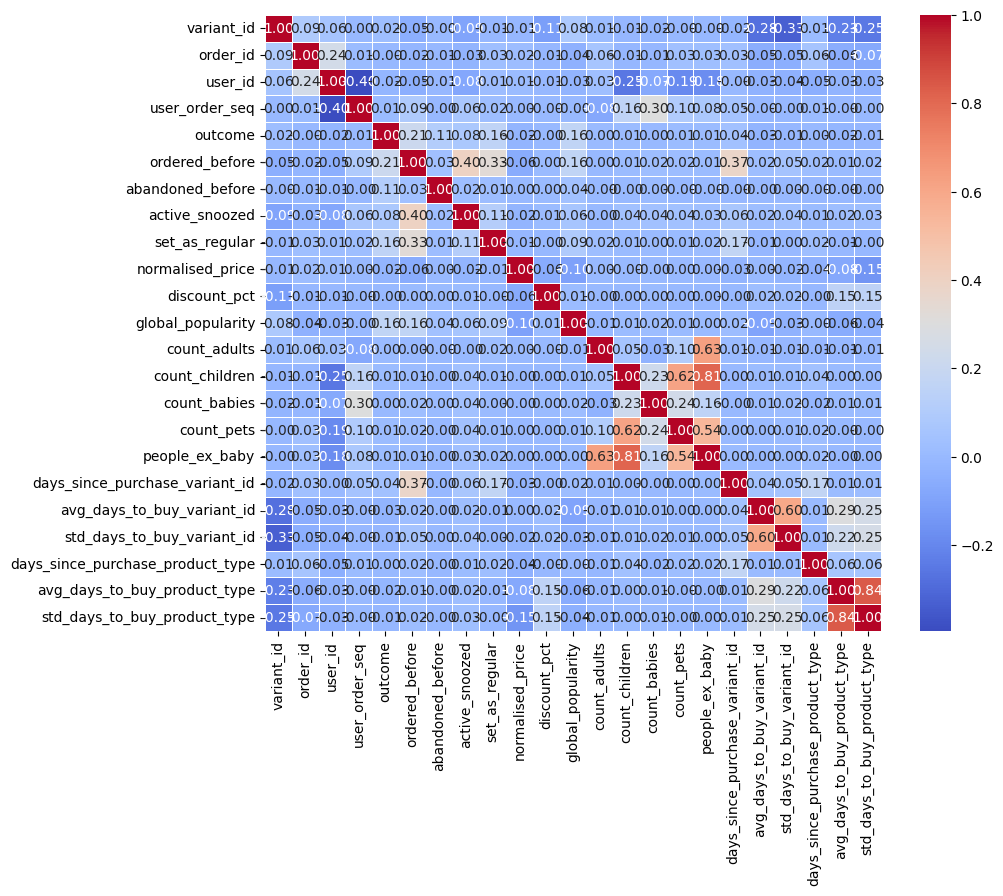

In [7]:
df = pd.DataFrame(filtered_data)
df_numeric = df.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))  # Puedes ajustar el tamaño a tus necesidades
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            cbar=True, square=True, linewidths=.5)

# Mostrar el gráfico
plt.show()


So my predictible variable will be "outcome", which will represent the probability of a user buying a determined product when a notification shows up.

For doing so, I`m first going to divide de dataset into X and y. I will for this purpose consider not relevant many columns such as the order_id for example. Nevertheless, I will include some details such as the day of the week that the order was made, the hour, or the year station.

In [12]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['order_date'] = pd.to_datetime(df['order_date'])

def get_season(month):
    if month in [12, 1, 2]:
        return 1  # Invierno
    elif month in [3, 4, 5]:
        return 2  # Primavera
    elif month in [6, 7, 8]:
        return 3  # Verano
    else:
        return 4  # Otoño


df['season'] = df['order_date'].dt.month.apply(get_season)

df['day_of_week'] = df['order_date'].dt.dayofweek
df['is_weekend'] = df['order_date'].dt.dayofweek >= 5
df['hour_of_day'] = df['order_date'].dt.hour

X = df.drop(['variant_id', 'order_id', 'user_id', 'created_at', 'order_date', 'outcome'], axis=1)
X = pd.concat([X, df[['day_of_week', 'is_weekend', 'hour_of_day']]], axis=1)
y = df['outcome']

logging.info("Las primeras filas de X son:\n%s", X.head().to_string())


2024-02-02 22:36:19,923 - INFO - Las primeras filas de X son:
       product_type  user_order_seq  ordered_before  abandoned_before  active_snoozed  set_as_regular  normalised_price  discount_pct       vendor  global_popularity  count_adults  count_children  count_babies  count_pets  people_ex_baby  days_since_purchase_variant_id  avg_days_to_buy_variant_id  std_days_to_buy_variant_id  days_since_purchase_product_type  avg_days_to_buy_product_type  std_days_to_buy_product_type  season  day_of_week  is_weekend  hour_of_day  day_of_week  is_weekend  hour_of_day
7   ricepastapulses              13             0.0               0.0             0.0             0.0          0.081052      0.053512  clearspring           0.038462           2.0             0.0           0.0         0.0             2.0                            33.0                        42.0                   31.134053                              30.0                          30.0                      24.27618       4       

Now that we have divided our X & y ; let's try to select among the variables we have, which ones are the most importants. For this purpose, I will use the Random Forest Classifier.

2024-02-02 23:09:22,163 - INFO - Los resultados de nuestro modelo son:
global_popularity                          1.854000e-01
days_since_purchase_product_type           1.074893e-01
user_order_seq                             1.021143e-01
days_since_purchase_variant_id             5.707631e-02
day_of_week                                4.536145e-02
day_of_week                                4.526885e-02
std_days_to_buy_variant_id                 4.305224e-02
avg_days_to_buy_variant_id                 3.827868e-02
ordered_before                             3.420040e-02
discount_pct                               3.382007e-02
normalised_price                           3.080749e-02
count_pets                                 2.205626e-02
season                                     1.862092e-02
set_as_regular                             1.771722e-02
people_ex_baby                             1.584812e-02
std_days_to_buy_product_type               1.484701e-02
count_children                   

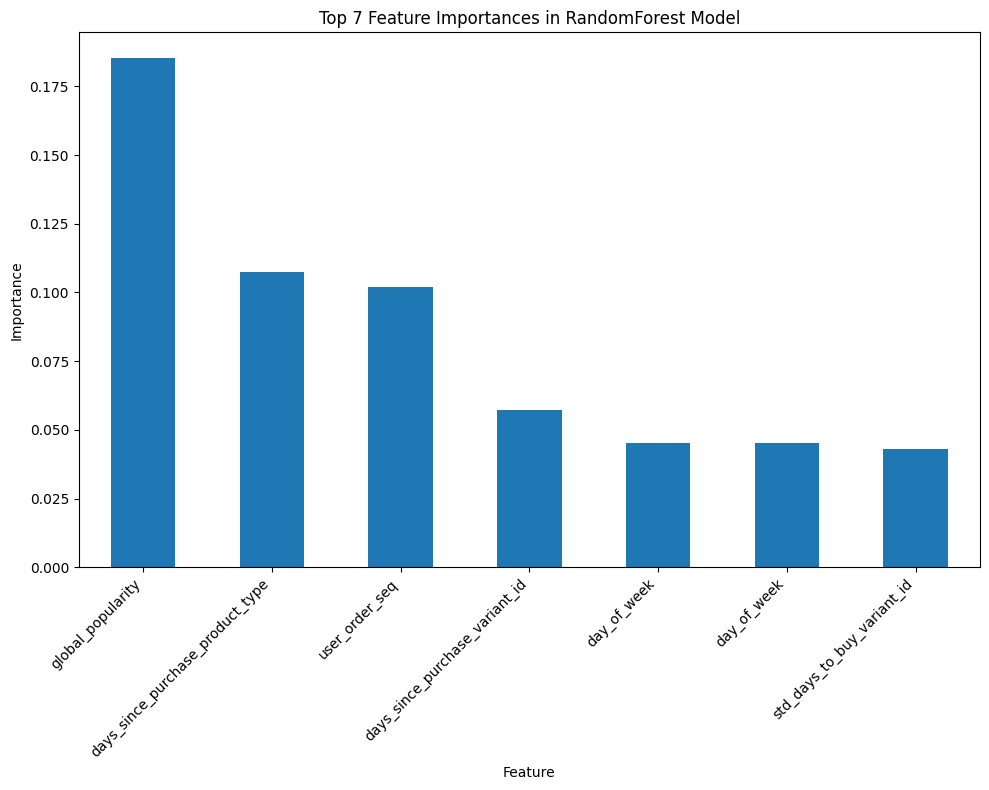

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_encoded = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

importances = model.feature_importances_

feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

logging.info("Los resultados de nuestro modelo son:\n%s", feature_importances.to_string())


# Graph of importances
top_features = feature_importances[:7]

# Gráfico de barras para las 7 características más importantes
plt.figure(figsize=(10, 8))
top_features.plot(kind='bar')
plt.title('Top 7 Feature Importances in RandomForest Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Ajusta la disposición para evitar la superposición de etiquetas
plt.show()

Based on the result of our model; we had obtained several conclutions:

"Global_popularity" is the most significant feature in your model with an importance of approximately 0.1837, indicating it greatly influences user interest predictions. "Days_since_purchase_product_type" and "user_order_seq" also matter, with importances around 0.1113 and 0.1029, showing they're key but less so than global popularity.

"Days_since_purchase_variant_id" and "day_of_week" have lower importances (about 0.0578 and 0.0447), suggesting their minor yet present impact on predictions. Features with minimal or zero importance, like vendor names and "hour_of_day" (notably listed twice with zero importance), appear to have little to no impact, hinting at potential data processing errors or interpretation issues.

Therefore, we are going to remove them.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train_reduced = X_train.drop(['vendor_munchkin', 'vendor_vicks', 'hour_of_day'], axis=1)
X_test_reduced = X_test.drop(['vendor_munchkin', 'vendor_vicks', 'hour_of_day'], axis=1)




NOW, LET'S START WITH LOGISTIC REGRESSION:




In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#first we standarize
scaler = StandardScaler()
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

model_lr = LogisticRegression(max_iter=1000)  
model_lr.fit(X_train_reduced_scaled, y_train)

#evaluating the model
y_pred = model_lr.predict(X_test_reduced_scaled)
accuracy = accuracy_score(y_test, y_pred)
logging.info("Accuracy of the Logistic Regression model: %s", accuracy)

#with more detail
report = classification_report(y_test, y_pred)
logging.info("Classification report:\n%s", report)


2024-02-02 23:47:07,639 - INFO - Accuracy of the Logistic Regression model: 0.9862261266860397
2024-02-02 23:47:07,857 - INFO - Classification report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     58698
         1.0       0.69      0.03      0.06       835

    accuracy                           0.99     59533
   macro avg       0.84      0.52      0.53     59533
weighted avg       0.98      0.99      0.98     59533



The Logistic Regression model achieves 98.62% accuracy, indicating high overall performance. However, it excels at identifying the majority class (0.0) with nearly 99% precision and 100% recall but struggles with the minority class (1.0), showing only 69% precision and a mere 3% recall. This discrepancy suggests difficulties in detecting the less frequent class, likely due to class imbalance. Macro averages reveal the challenge with a lower performance on the minority class.

For this purpose, I am just going to redo the logistic regression as follows, with the aim of assigning weights inversely proportional to class frequencies. This ensures less frequent classes gain higher importance during training, enhancing model performance on these classes.



In [32]:
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced')
model_lr.fit(X_train_reduced_scaled, y_train)
#evaluating the model
y_pred = model_lr.predict(X_test_reduced_scaled)
accuracy = accuracy_score(y_test, y_pred)
logging.info("Accuracy of the Logistic Regression model: %s", accuracy)

#with more detail
report = classification_report(y_test, y_pred)
logging.info("Classification report:\n%s", report)


2024-02-02 23:55:30,889 - INFO - Accuracy of the Logistic Regression model: 0.8398535266154906
2024-02-02 23:55:31,091 - INFO - Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     58698
         1.0       0.06      0.66      0.10       835

    accuracy                           0.84     59533
   macro avg       0.53      0.75      0.51     59533
weighted avg       0.98      0.84      0.90     59533



The use of class_weight='balanced' likely improved recall for the minority class at the cost of precision, demonstrating the trade-off between detecting minority class instances and maintaining accuracy in predictions.

LET'S NOW PROCEED WITH RIDGE REGRESSION:

we know that by adding a degree of bias to the regression estimates, ridge regression reduces the standard errors. It is used to analyze data that suffers from multicollinearity (independent variables are highly correlated). In multicollinearity, even though the least squares estimates (OLS) are unbiased, their variances can be large, and they may be far from the true value. Ridge regression improves the prediction accuracy by shrinking the regression coefficients to avoid overfitting but introduces some bias into the estimates. This trade-off between reducing variance and introducing bias makes ridge regression particularly useful when dealing with ill-posed problems or when preventing overfitting

In [33]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_reduced_scaled, y_train)

# Evaluate the model
y_pred = model_lr.predict(X_test_reduced_scaled)
accuracy = accuracy_score(y_test, y_pred)
logging.info("Accuracy of the Logistic Regression model: %s", accuracy)

#with more detail
report = classification_report(y_test, y_pred)
logging.info("Classification report:\n%s", report)

2024-02-03 00:27:43,721 - INFO - Accuracy of the Logistic Regression model: 0.8398535266154906
2024-02-03 00:27:43,892 - INFO - Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     58698
         1.0       0.06      0.66      0.10       835

    accuracy                           0.84     59533
   macro avg       0.53      0.75      0.51     59533
weighted avg       0.98      0.84      0.90     59533

